# Stock Market Prediction using ARIMA and Gradient Boosting Models

## Introduction
This notebook demonstrates the process of predicting stock market prices using ARIMA for time-series analysis and Gradient Boosting for machine learning. It includes data preparation, exploratory data analysis, feature engineering, hyperparameter tuning, and model evaluation.

## Step 1: Data Preparation

### Import Libraries

In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

### Download Data

In [12]:
# Download historical stock data for selected equities
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
data = yf.download(tickers, start='2015-01-01', end='2025-01-01', group_by='ticker')

# Save data for one stock (example: AAPL)
stock_data = data['AAPL']
stock_data.reset_index(inplace=True)
stock_data = stock_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
stock_data.set_index('Date', inplace=True)

[*********************100%***********************]  5 of 5 completed


### Handle Missing Values

In [13]:
# Fill missing values
stock_data = stock_data.fillna(method='ffill')

## Step 2: Exploratory Data Analysis (EDA)

### Visualize Trends

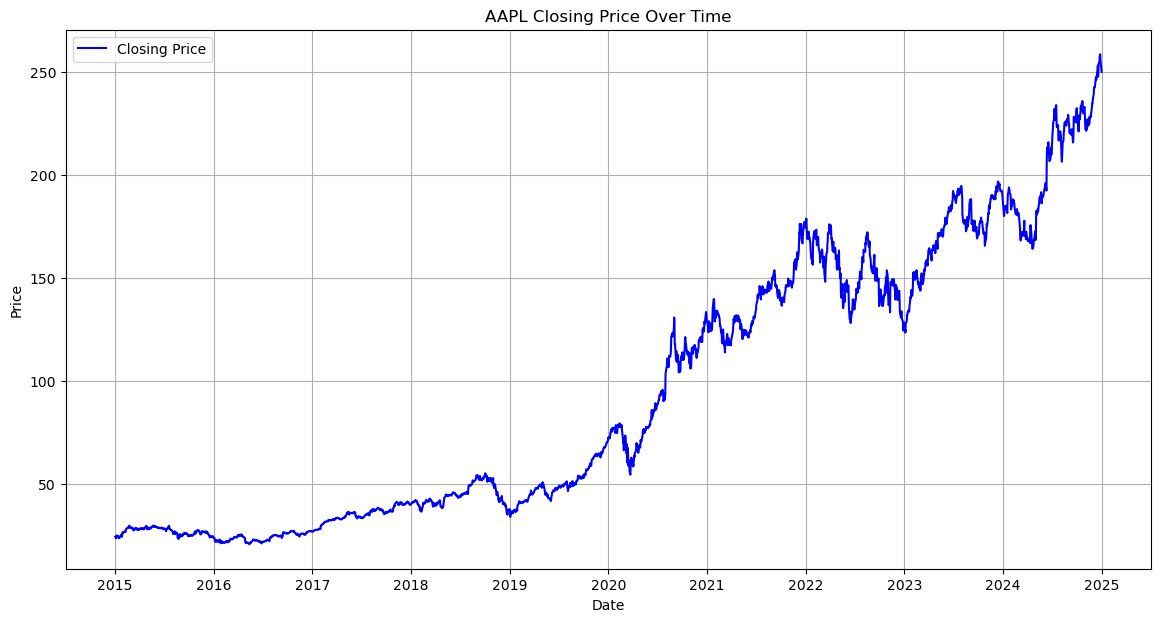

In [14]:
# Plot closing prices
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Closing Price', color='blue')
plt.title('AAPL Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

### Moving Averages

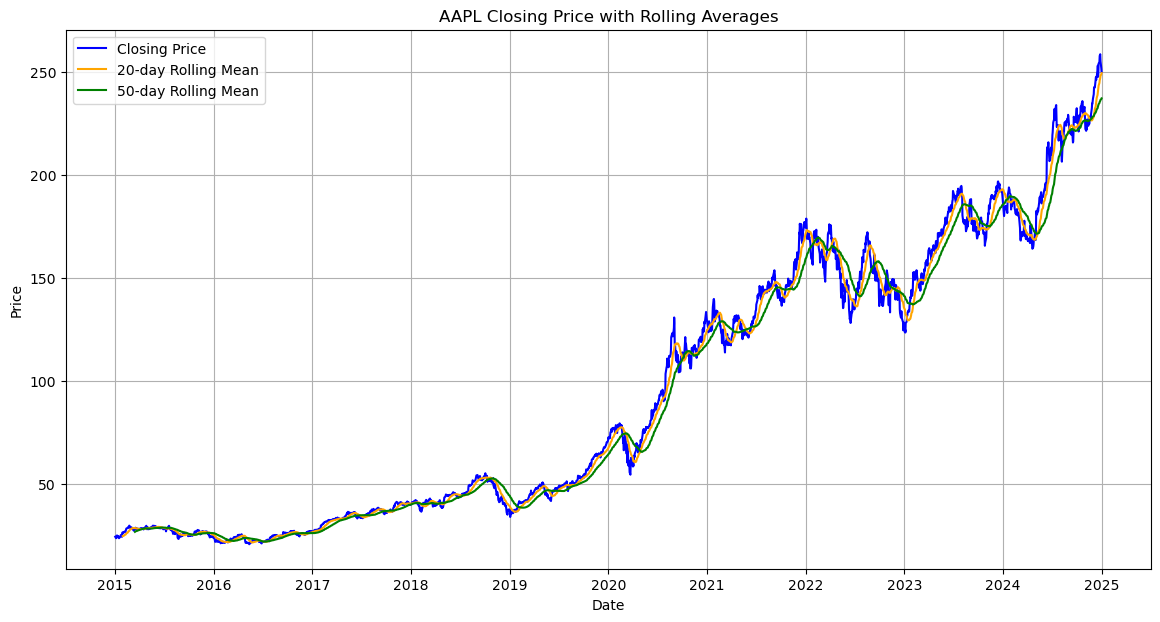

In [15]:
# Add rolling averages for visualization
stock_data['Rolling_Mean_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['Rolling_Mean_50'] = stock_data['Close'].rolling(window=50).mean()

# Plot closing prices and rolling means
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Closing Price', color='blue')
plt.plot(stock_data['Rolling_Mean_20'], label='20-day Rolling Mean', color='orange')
plt.plot(stock_data['Rolling_Mean_50'], label='50-day Rolling Mean', color='green')
plt.title('AAPL Closing Price with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Step 3: Feature Engineering

### Create Features

In [16]:
# Create lagged features
stock_data['Lag_1'] = stock_data['Close'].shift(1)

# Create rolling mean
stock_data['Rolling_Mean_5'] = stock_data['Close'].rolling(window=5).mean()

# Percentage change
stock_data['Pct_Change'] = stock_data['Close'].pct_change()

# Drop rows with NA values
stock_data.dropna(inplace=True)

## Step 4: Modeling

### ARIMA Model with Hyperparameter Tuning

In [18]:
# Define parameter ranges for ARIMA
p = range(0, 5)
d = range(0, 2)
q = range(0, 5)
pdq_combinations = list(itertools.product(p, d, q))

best_rmse_arima = float("inf")
best_pdq = None

# Grid search for ARIMA parameters
for pdq in pdq_combinations:
    try:
        model = ARIMA(stock_data['Close'], order=pdq)
        results = model.fit()
        forecast = results.forecast(steps=10)
        actual = stock_data['Close'].iloc[-10:]  # Last 10 actual values
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        if rmse < best_rmse_arima:
            best_rmse_arima = rmse
            best_pdq = pdq
    except:
        continue

print(f"Best Parameters for ARIMA: {best_pdq}")
print(f"Best ARIMA RMSE: {best_rmse_arima}")

# Fit final ARIMA model
final_arima_model = ARIMA(stock_data['Close'], order=best_pdq).fit()

Best Parameters for ARIMA: (2, 1, 1)
Best ARIMA RMSE: 4.295454546667503


### Gradient Boosting Model with Hyperparameter Tuning

In [19]:
# Define features and target variable
features = ['Lag_1', 'Rolling_Mean_5', 'Pct_Change']
X = stock_data[features]
y = stock_data['Close']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize Gradient Boosting model
xgb_model = XGBRegressor(random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
print("Best Parameters for Gradient Boosting:", grid_search.best_params_)

# Evaluate tuned model
y_pred_tuned = best_model.predict(X_test)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
print(f"Tuned Gradient Boosting RMSE: {rmse_tuned}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters for Gradient Boosting: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Tuned Gradient Boosting RMSE: 0.9909758010679852


## Step 5: Model Evaluation

## Step 6: Conclusions and Recommendations
*1. ARIMA Model* : Suitable for time-dependent patterns and short-term trend predictions.

*2. Gradient Boosting Model*: Performs well with engineered features, handling sudden fluctuations effectively.

#### Recommendations:

* Combine both models for hybrid predictions.

* Use ARIMA for stable trends and Gradient Boosting for capturing non-linear relationships.